**IMPORTING LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import keras
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**IMPORTING THE AGGREGATED DATASET**

In [2]:
aggrDataset = pd.read_csv('NIFTY50_all.csv')

**HEATMAP (INCLUDING ALL FEATURES)**

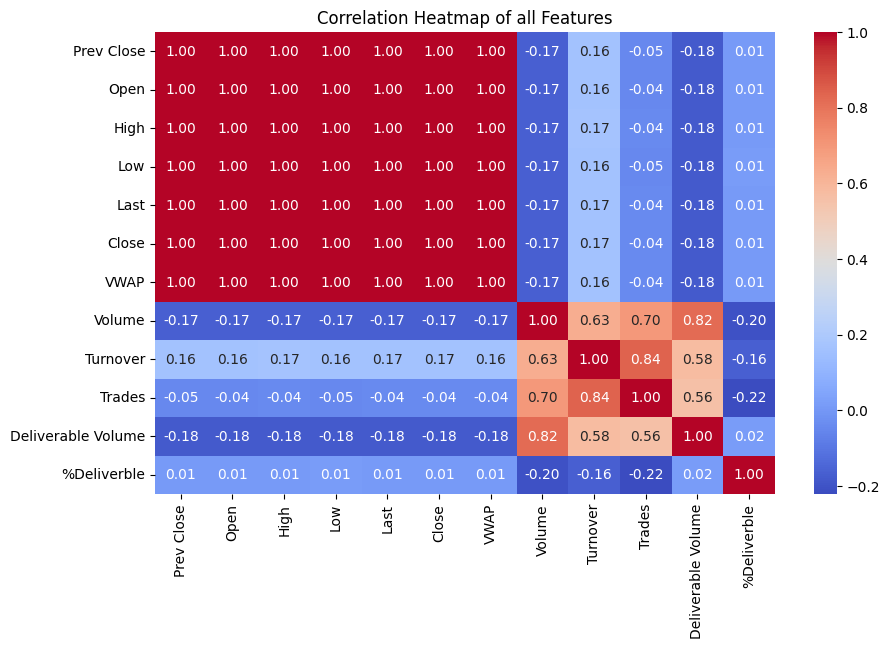

In [3]:
columns_to_exclude = ['Date', 'Symbol', 'Series']
dataset_filtered = aggrDataset.drop(columns=columns_to_exclude)
plt.figure(figsize=(10, 6))
sns.heatmap(dataset_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of all Features')
plt.show()

**HEATMAP (EXCLUDING IRRELEVANT FEATURES)**

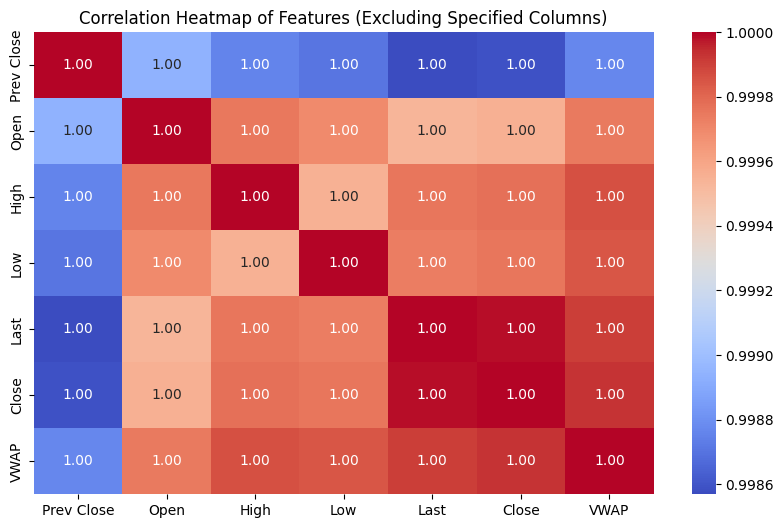

In [4]:
columns_to_exclude = ['Date', 'Symbol', 'Series', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']
dataset_filtered = aggrDataset.drop(columns=columns_to_exclude)
plt.figure(figsize=(10, 6))
sns.heatmap(dataset_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features (Excluding Specified Columns)')
plt.show()

**IMPORTING DATASETS**

In [5]:
def process_data(file_names):
    data_dict = {}
    for file_name in file_names:
        df = pd.read_csv(file_name)
        data_dict[file_name] = df
    return data_dict

file_names = ['ADANIPORTS.csv', 'ASIANPAINT.csv', 'AXISBANK.csv', 'BAJAJ-AUTO.csv', 'BAJFINANCE.csv', 'BHARTIARTL.csv', 'BPCL.csv', 'CIPLA.csv', 'DRREDDY.csv', 'GAIL.csv', 'GRASIM.csv', 'HCLTECH.csv', 'HDFC.csv', 'HDFCBANK.csv', 'HEROMOTOCO.csv', 'HINDALCO.csv', 'HINDUNILVR.csv', 'ICICIBANK.csv', 'INFY.csv', 'IOC.csv', 'ITC.csv', 'JSWSTEEL.csv', 'KOTAKBANK.csv', 'LT.csv', 'MM.csv', 'NTPC.csv', 'ONGC.csv', 'POWERGRID.csv', 'RELIANCE.csv', 'SBIN.csv', 'SUNPHARMA.csv', 'TATAMOTORS.csv', 'TATASTEEL.csv', 'TCS.csv', 'TECHM.csv', 'TITAN.csv', 'UPL.csv', 'VEDL.csv', 'WIPRO.csv', 'ZEEL.csv']
data_dict = process_data(file_names)

**CHECKING NUMBER OF ROWS AND COLUMNS**

In [6]:
for file_name, df in data_dict.items():
    print(f"Shape of {file_name}: {df.shape}")

Shape of ADANIPORTS.csv: (3322, 15)
Shape of ASIANPAINT.csv: (5306, 15)
Shape of AXISBANK.csv: (5306, 15)
Shape of BAJAJ-AUTO.csv: (3202, 15)
Shape of BAJFINANCE.csv: (5235, 15)
Shape of BHARTIARTL.csv: (4774, 15)
Shape of BPCL.csv: (5306, 15)
Shape of CIPLA.csv: (5306, 15)
Shape of DRREDDY.csv: (5306, 15)
Shape of GAIL.csv: (4985, 15)
Shape of GRASIM.csv: (5306, 15)
Shape of HCLTECH.csv: (5300, 15)
Shape of HDFC.csv: (5306, 15)
Shape of HDFCBANK.csv: (5306, 15)
Shape of HEROMOTOCO.csv: (5306, 15)
Shape of HINDALCO.csv: (5306, 15)
Shape of HINDUNILVR.csv: (5306, 15)
Shape of ICICIBANK.csv: (5306, 15)
Shape of INFY.csv: (5306, 15)
Shape of IOC.csv: (5306, 15)
Shape of ITC.csv: (5306, 15)
Shape of JSWSTEEL.csv: (3994, 15)
Shape of KOTAKBANK.csv: (4985, 15)
Shape of LT.csv: (4184, 15)
Shape of MM.csv: (5306, 15)
Shape of NTPC.csv: (4088, 15)
Shape of ONGC.csv: (5306, 15)
Shape of POWERGRID.csv: (3359, 15)
Shape of RELIANCE.csv: (5306, 15)
Shape of SBIN.csv: (5306, 15)
Shape of SUNPHARMA.c

**DIVIDING TABLE IN DEPENDENT AND INDEPENDENT VARIABLE**

In [7]:
X_dict = {}
y_dict = {}
columns_to_drop = ['Close', 'Symbol', 'Series', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']

for file_name, df in data_dict.items():
    X = df.drop(columns=columns_to_drop)
    y = df['Close']
    X_dict[file_name] = X
    y_dict[file_name] = y

**SPLITTING THE DATASET**

In [8]:
X_train_dict, X_val_dict, X_test_dict = {}, {}, {}
y_train_dict, y_val_dict, y_test_dict = {}, {}, {}

train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20

for file_name, X in X_dict.items():

    y = y_dict[file_name]

    total_size = len(X)
    train_size = int(total_size * train_ratio)
    validation_size = int(total_size * validation_ratio)

    if total_size > 1:
        X_train_dict[file_name] = X.iloc[:train_size, :]
        y_train_dict[file_name] = y.iloc[:train_size]
        X_val_dict[file_name] = X.iloc[train_size:train_size + validation_size, :]
        y_val_dict[file_name] = y.iloc[train_size:train_size + validation_size]
        X_test_dict[file_name] = X.iloc[train_size + validation_size:, :]
        y_test_dict[file_name] = y.iloc[train_size + validation_size:]

**FEATURE SCALING**

In [9]:
scaler_X = StandardScaler()

for file_name, X_train in X_train_dict.items():

    X_train_copy = X_train.copy()
    X_train_copy.iloc[:, 1:] = scaler_X.fit_transform(X_train_copy.iloc[:, 1:].values)
    X_train_dict[file_name] = X_train_copy

    X_val_dict[file_name] = X_val_dict[file_name].copy()
    X_val_dict[file_name].iloc[:, 1:] = scaler_X.transform(X_val_dict[file_name].iloc[:, 1:].values)

    X_test_dict[file_name] = X_test_dict[file_name].copy()
    X_test_dict[file_name].iloc[:, 1:] = scaler_X.transform(X_test_dict[file_name].iloc[:, 1:].values)

**INPUTTING THE COMPANY WHOSE STOCK WE WANT TO PREDICT**

In [10]:
str = input("Enter the company name: ").upper()
file_name = str + ".csv"

Enter the company name: powergrid


**IMPORTING PARTICULAR DATASET FOR EDA**

In [11]:
dataset = pd.read_csv(file_name)

**CHANGING DATE**

In [12]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

dataset['Date'] = dataset['Date'].apply(str_to_datetime)
dataset.index = dataset.pop('Date')

**TIME SERIES PLOT (OPEN and CLOSE)**

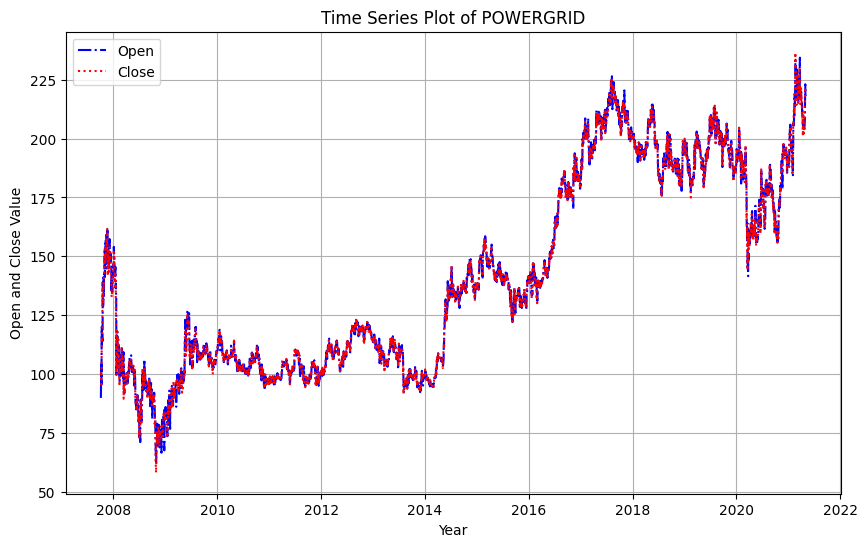

In [13]:
dates = dataset.index
open = dataset['Open']
close = dataset['Close']
plt.figure(figsize=(10, 6))
plt.plot(dates, open, label='Open', linestyle='-.', color='blue')
plt.plot(dates, close, label='Close', linestyle=':', color='red')
plt.title(f'Time Series Plot of {str}')
plt.xlabel('Year')
plt.ylabel('Open and Close Value')
plt.legend()
plt.grid(True)
plt.show()

**TIME SERIES PLOT (HIGH and LOW)**

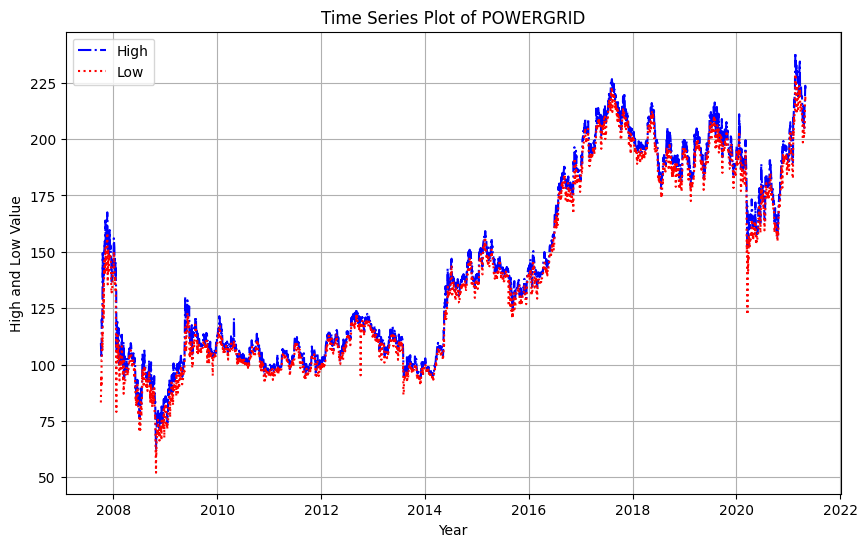

In [14]:
high = dataset['High']
low = dataset['Low']
plt.figure(figsize=(10, 6))
plt.plot(dates, high, label='High', linestyle='-.', color='blue')
plt.plot(dates, low, label='Low', linestyle=':', color='red')
plt.title(f'Time Series Plot of {str}')
plt.xlabel('Year')
plt.ylabel('High and Low Value')
plt.legend()
plt.grid(True)
plt.show()

**TIME SERIES PLOT (VWAP)**

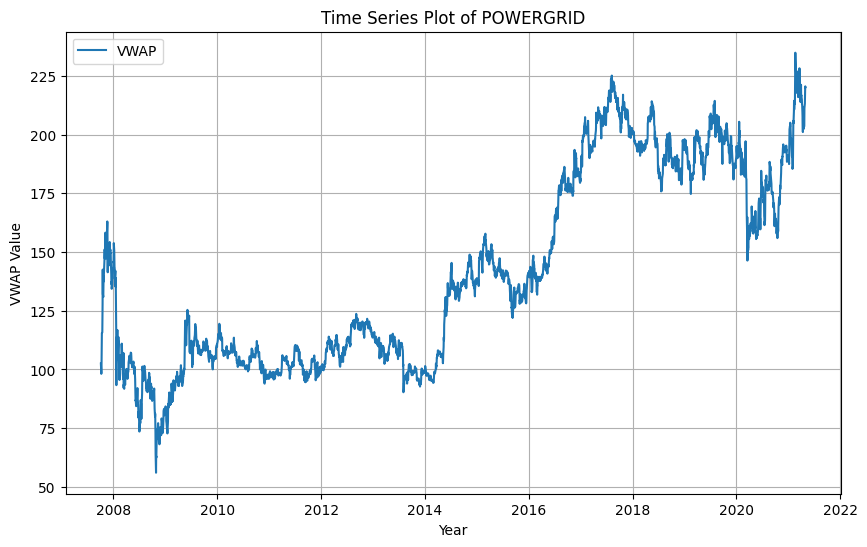

In [15]:
vwap = dataset['VWAP']
plt.figure(figsize=(10, 6))
plt.plot(dates, vwap, label='VWAP')
plt.title(f'Time Series Plot of {str}')
plt.xlabel('Year')
plt.ylabel('VWAP Value')
plt.legend()
plt.grid(True)
plt.show()

**TRAINING THE LSTM MODEL**

Epoch 1/400
74/74 [==============================] - 4s 15ms/step - loss: 12407.2246 - mean_absolute_error: 108.5599 - val_loss: 17702.8066 - val_mean_absolute_error: 132.6603
Epoch 2/400
74/74 [==============================] - 0s 6ms/step - loss: 1802.6287 - mean_absolute_error: 32.4752 - val_loss: 2840.0579 - val_mean_absolute_error: 52.2928
Epoch 3/400
74/74 [==============================] - 1s 8ms/step - loss: 147.4861 - mean_absolute_error: 8.4897 - val_loss: 1280.5201 - val_mean_absolute_error: 34.4968
Epoch 4/400
74/74 [==============================] - 1s 8ms/step - loss: 55.6965 - mean_absolute_error: 5.2057 - val_loss: 360.7274 - val_mean_absolute_error: 17.0004
Epoch 5/400
74/74 [==============================] - 1s 9ms/step - loss: 29.9500 - mean_absolute_error: 3.7895 - val_loss: 199.6216 - val_mean_absolute_error: 12.0275
Epoch 6/400
74/74 [==============================] - 1s 7ms/step - loss: 15.0346 - mean_absolute_error: 2.5741 - val_loss: 153.7759 - val_mean_absolut

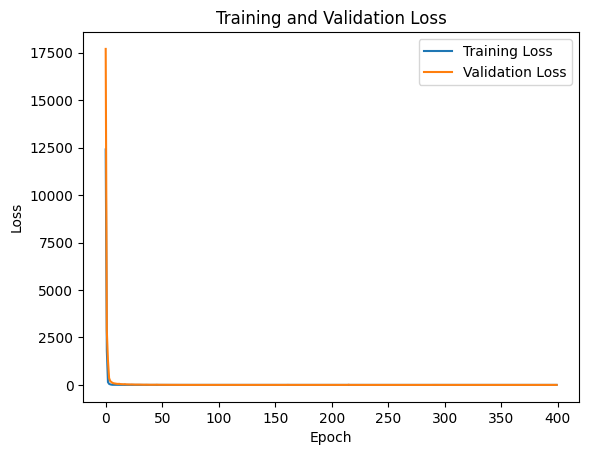

In [16]:
time_step = 5

X_train = X_train_dict[file_name]
y_train = y_train_dict[file_name]

X_train_reshaped = []
y_train_reshaped = []

for i in range(len(X_train) - time_step + 1):
    X_train_reshaped.append(X_train.iloc[i:i + time_step, 1:].values.reshape(1, time_step, X_train.shape[1] - 1))
    y_train_reshaped.append(y_train.iloc[i + time_step - 1])

X_train_reshaped = np.concatenate(X_train_reshaped, axis=0)
y_train_reshaped = np.array(y_train_reshaped)

X_val = X_val_dict[file_name]
y_val = y_val_dict[file_name]

X_val_reshaped = []
y_val_reshaped = []

for i in range(len(X_val) - time_step + 1):
    X_val_reshaped.append(X_val.iloc[i:i + time_step, 1:].values.reshape(1, time_step, X_val.shape[1] - 1))
    y_val_reshaped.append(y_val.iloc[i + time_step - 1])

X_val_reshaped = np.concatenate(X_val_reshaped, axis=0)
y_val_reshaped = np.array(y_val_reshaped)

# Define the model
model = Sequential([
    LSTM(64, input_shape=(time_step, X_train.shape[1] - 1)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mean_absolute_error']
)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_reshaped, y_train_reshaped,
                    validation_data=(X_val_reshaped, y_val_reshaped),
                    epochs=400,
                    callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**CHANGING THE DATE**

In [17]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

X_train['Date'] = X_train['Date'].apply(str_to_datetime)
X_train.index = X_train.pop('Date')

**MAKING PREDICTION AND VISUALIZATION (TRAINING SET)**

74/74 [==============================] - 1s 4ms/step


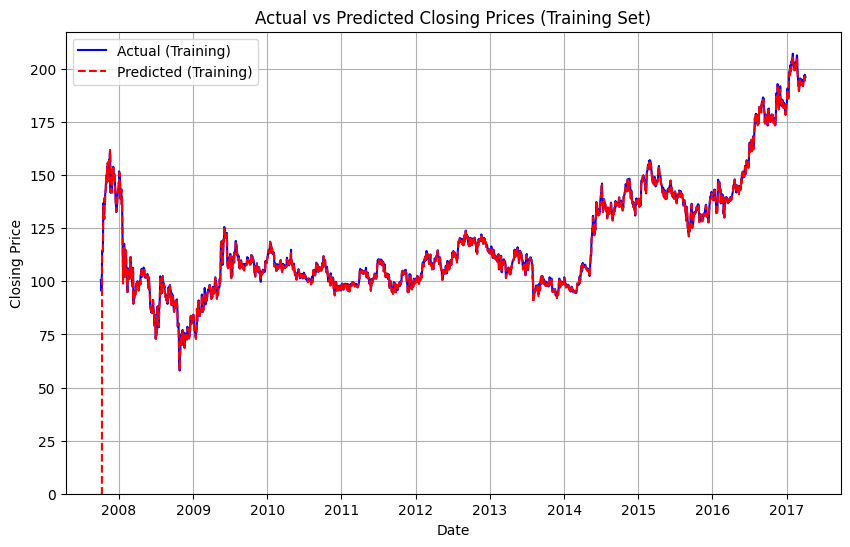

In [18]:
# Predictions on training set
dates = X_train.index

train_predictions = model.predict(X_train_reshaped)

# Reshape predictions to match the original shape of the training data
train_predictions_original_shape = np.zeros_like(y_train.values)
train_predictions_original_shape[time_step - 1:] = train_predictions.reshape(-1)

# Plot actual vs predicted values for training set
plt.figure(figsize=(10, 6))
plt.plot(dates, y_train.values, label='Actual (Training)', color='blue', linestyle='-')
plt.plot(dates, train_predictions_original_shape, label='Predicted (Training)', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Prices (Training Set)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)  # Add grid for better visualization
plt.ylim(bottom=0)
plt.show()

**MAKING PREDICTION AND VISUALIZATION (TEST SET)**

21/21 [==============================] - 0s 2ms/step


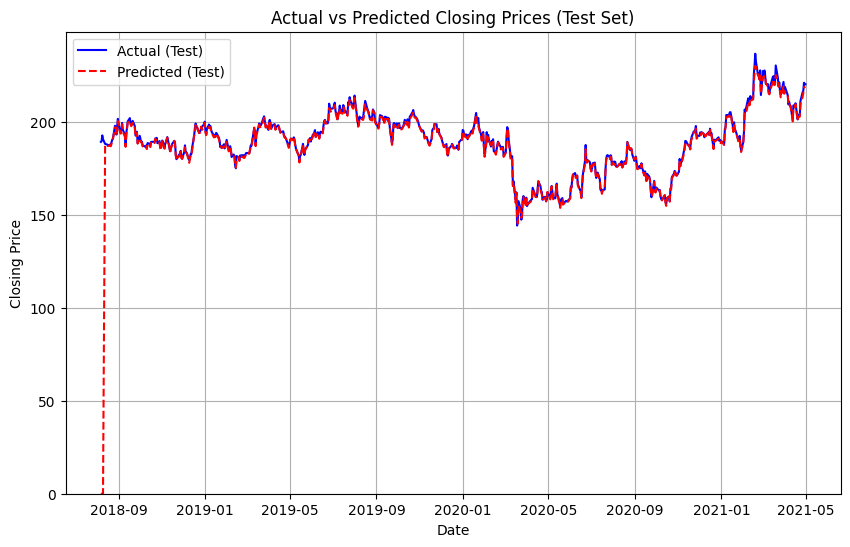

In [19]:
X_test = X_test_dict[file_name]
y_test = y_test_dict[file_name]

X_test_reshaped = []
for i in range(len(X_test) - time_step + 1):
    X_test_reshaped.append(X_test.iloc[i:i + time_step, 1:].values.reshape(1, time_step, X_test.shape[1] - 1))

X_test_reshaped = np.concatenate(X_test_reshaped, axis=0)

# Predictions on test set
test_predictions = model.predict(X_test_reshaped)

# Reshape predictions to match the original shape of the test data
test_predictions_original_shape = np.zeros_like(y_test.values)
test_predictions_original_shape[time_step - 1:] = test_predictions.reshape(-1)

X_test['Date'] = X_test['Date'].apply(str_to_datetime)
X_test.index = X_test.pop('Date')
dates = X_test.index

# Set colors and line styles for better differentiation
actual_color = 'blue'
predicted_color = 'red'
actual_line_style = '-'
predicted_line_style = '--'

# Plot actual vs predicted values for test set
plt.figure(figsize=(10, 6))
plt.plot(dates, y_test.values, label='Actual (Test)', color=actual_color, linestyle=actual_line_style)
plt.plot(dates, test_predictions_original_shape, label='Predicted (Test)', color=predicted_color, linestyle=predicted_line_style)
plt.title('Actual vs Predicted Closing Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)  # Add grid for better visualization
plt.ylim(bottom=0)
plt.show()

**PERFORMANCE METRICS**

In [20]:
mse = mean_squared_error(y_test_dict[file_name].iloc[time_step - 1:], test_predictions)
print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test_dict[file_name].iloc[time_step - 1:], test_predictions)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_test_dict[file_name].iloc[time_step - 1:], test_predictions)
print(f"R-squared (R2) Error: {r2}")

Mean Squared Error: 0.9884101919744795
Mean Absolute Error: 0.7404162989959953
R-squared (R2) Error: 0.9960867881047062


**PREDICTION OF FUTURE STOCK PRICE**

In [21]:
# Define the number of days to predict
num_days_to_predict = 1

# Take the last few days' stock prices from the test set
last_few_days_prices = y_test.iloc[-time_step:].values.reshape(-1, 1)

# Ensure that the number of features matches the scaler's expectations
num_features = X_test.shape[1]
last_few_days_prices = np.tile(last_few_days_prices, (1, num_features))

# Scale the input data using the same scaler used during training
scaled_last_few_days_prices = scaler_X.transform(last_few_days_prices)
scaled_last_few_days_prices = scaled_last_few_days_prices.reshape(1, time_step, num_features)

# Initialize an empty list to store the predicted stock values for the next few days
predicted_stock_values = []

for day in range(num_days_to_predict):
    # Predict the next day's stock value
    next_day_prediction = model.predict(scaled_last_few_days_prices)
    predicted_stock_values.append(next_day_prediction[0, 0])

    print(f"Day {day + 1} - Input Sequence: {scaled_last_few_days_prices[0, :, 0]}")

    scaled_last_few_days_prices = np.roll(scaled_last_few_days_prices, -1, axis=1)

    latest_close_price = next_day_prediction.reshape(-1, 1)

    dummy_array = np.zeros((1, num_features - 1))

    scaled_latest_close_price = np.hstack((latest_close_price, dummy_array))

    scaled_latest_close_price = scaled_latest_close_price.reshape(1, -1)

    scaled_latest_close_price = scaler_X.transform(scaled_latest_close_price)

    scaled_latest_close_price = scaled_latest_close_price.reshape(1, 1, -1)

    scaled_last_few_days_prices[0, -1, :] = scaled_latest_close_price[0, 0, :]

print("\nPredicted Stock Values for the Next Day:")
for i, predicted_value in enumerate(predicted_stock_values, start=1):
    print(f"Day {i}: {predicted_value}")

1/1 [==============================] - 0s 24ms/step
Day 1 - Input Sequence: [-0.03513705 -0.03011078 -0.00497946 -0.0094144  -0.01000572]

Predicted Stock Values for the Next Day:
Day 1: 118.26124572753906
